In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

import MiraTitanHMFemulator

print("Version", MiraTitanHMFemulator.__version__)

Version 0.1.1


In [2]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations, get_power

In [3]:
HMFemu = MiraTitanHMFemulator.Emulator()

In [33]:
## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
Omegac  = Omegam - Omegab
OmegaDE = 1.0-Omegam
w_DE_0  = -0.9999
w_DE_a  = 0.0
cs2_DE  = 1.0
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Neff    = 2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
h       = 0.67742
sigma_8 = 0.8159
n_s     = 0.96822
k_p     = 0.05

zout    = 0.0
aout    = 1.0/(1.0+zout)


In [35]:

# param = {}
# param['Omegam']  = Omegam
# param['Omegab']  = Omegab
# param['OmegaDE'] = OmegaDE
# param['w_DE_0']  = w_DE_0
# param['w_DE_a']  = w_DE_a
# param['cs2_DE']  = cs2_DE
# param['Omegak']  = 0.0
# param['A_s'] = 2.1064e-09
# param['n_s']     = n_s
# param['H0']      = 100*h
# param['Tcmb']    = Tcmb
# param['YHe']     = YHe
# param['Neff']    = Neff
# param['Nmnu']    = num_massive_neutrinos
# param['mnu']     = mnu
# param['k_p']     = k_p
# param['sigma_8'] = sigma_8


# ## Compute Background evolution
# param = evolve_background(param=param, thermo_module='RECFAST')



In [36]:


# # modes to sample
# nmodes = 512
# kmin = 1e-3
# kmax = 1e+2
# aexp = 1

# aexp_out = jnp.array([aexp]) #jnp.geomspace(1e-3,1,2)

# y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out )

In [37]:
# Pkm = get_power( k=kmodes, y=y[:,-1,:], idx=4, param=param )

# Wth = lambda kR : 3*(jnp.sin(kR)-kR*jnp.cos(kR))/(kR)**3
# dsigma = Wth(kmodes*8.0/h)**2 * Pkm * kmodes**2

# sigma8_2_measured = jnp.trapz( y=(kmodes*dsigma), x=jnp.log(kmodes) ) / (2*jnp.pi)

# Pkm  = Pkm  * param['sigma_8']**2 / sigma8_2_measured

In [38]:
def get_sigma_M_( *, M, Pkm, kmodes, param ):
    """ compute the variance of the density field smoothed on a scale R
    
    Args:
        Pkm (array_like) : the power spectrum
        kmodes (array_like) : the wavenumbers
        M (array_like) : the mass
        param (dict) : dictionary of all parameters
        
    Returns:
        sigma (array_like) : the variance
    """
    rho_crit = 1e-4*param['H0']**2 * 2.77440334e11 # Msun / Mpc
    Wth = lambda kR : 3*(jnp.sin(kR)-kR*jnp.cos(kR))/(kR)**3
    R = (3*M/(4*jnp.pi*param['Omegam']*rho_crit))**(1/3)


    dsigma = Wth(kmodes*R)**2 * Pkm * kmodes**2
    return jnp.sqrt(jnp.trapz( y=(kmodes*dsigma), x=jnp.log(kmodes) ) / (2*jnp.pi))

def get_sigma_M( *, M, Pkm, kmodes, param ):
    return jax.vmap( lambda mm: get_sigma_M_(M=mm, Pkm=Pkm, kmodes=kmodes, param=param) )(M)

In [39]:
# def get_Tinker_MK( *, Pkm, kmodes, Mmin=1e13, Mmax=1e16, nM=512, Delta = 200, param ):
#     rho_crit = 1e-4*param['H0']**2 * 2.77440334e11 # Msun / Mpc
#     rhobar = param['Omegam']*rho_crit

#     M = jnp.geomspace( Mmin, Mmax, nM )
#     sigmaM = get_sigma_M( Pkm=Pkm, kmodes=kmodes, M=M, param=param )

#     dinvlogsigma_dM_func = jax.grad( lambda mm: jnp.log(1/get_sigma_M_( Pkm=Pkm, kmodes=kmodes, M=mm, param=param)) )
#     dinvlogsigma_dM = jax.vmap( dinvlogsigma_dM_func )(M)

#     # defintions for ∆ = 200
#     # A = 0.186
#     # a = 1.47
#     # b = 2.57
#     # c = 1.19
#     A = 0.1 * jnp.log10(Delta) - 0.05
#     a = 1.43 + (jnp.log10(Delta)-2.3)**1.5
#     b = 1.0 + (jnp.log10(Delta)-1.6)**(-1.5)
#     c = 1.2 + (jnp.log10(Delta)-2.35)**1.6

#     fsigma = A * ((sigmaM/b)**(-a) + 1) * jnp.exp(-c/sigmaM**2)

#     dndM = fsigma * rhobar / M * dinvlogsigma_dM 
#     return dndM, M

In [40]:
def get_Tinker_coeffs( Delta ):
  vDelta = jnp.array([200, 300, 400, 600, 800, 1200, 1600, 2400, 3200])
  vA = jnp.array([0.186, 0.200, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260])
  va = jnp.array([1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66])
  vb = jnp.array([2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41])
  vc = jnp.array([1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44])

  A = jnp.interp( jnp.log10(Delta), jnp.log10(vDelta), vA )
  a = jnp.interp( jnp.log10(Delta), jnp.log10(vDelta), va )
  b = jnp.interp( jnp.log10(Delta), jnp.log10(vDelta), vb )
  c = jnp.interp( jnp.log10(Delta), jnp.log10(vDelta), vc )

  return A, a, b, c

In [194]:
def compute_Tinker_MF( theta ):
  param = {}
  param['Omegam']  = theta[0]
  param['Omegab']  = theta[1]
  param['OmegaDE'] = 1 - param['Omegam']
  param['w_DE_0']  = theta[2]
  param['w_DE_a']  = theta[3]-1
  param['cs2_DE']  = 1.0
  param['Omegak']  = 0.0
  param['A_s']     = 2.1064e-09
  param['n_s']     = theta[4]
  param['H0']      = 100*theta[5]
  h = theta[5]
  param['Tcmb']    = 2.7255
  param['YHe']     = 0.248
  param['Neff']    = 2.046
  param['Nmnu']    = 1.0
  param['mnu']     = theta[6]
  param['k_p']     = 0.05
  param['sigma_8'] = theta[7]

  # compute background evolution and thermal history
  param = evolve_background(param=param, thermo_module='RECFAST')

  # compute perturbations at aexp = theta[8]
  nmodes = 512
  kmin = 1e-3
  kmax = 1e+2

  aexp_out = jnp.array([theta[8], 1.0])
  y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out )

  # get power spectrum, normalised to sigma_8
  Pkm0 = get_power( k=kmodes, y=y[:,-1,:], idx=4, param=param )
  Pkm  = get_power( k=kmodes, y=y[:,0,:], idx=4, param=param )

  Wth = lambda kR : 3*(jnp.sin(kR)-kR*jnp.cos(kR))/(kR)**3
  dsigma0 = Wth(kmodes*8.0/h)**2 * Pkm0 * kmodes**2

  sigma8_2_measured = jnp.trapz( y=(kmodes*dsigma0), x=jnp.log(kmodes) ) / (2*jnp.pi)

  Pkm  = Pkm  * param['sigma_8']**2 / sigma8_2_measured

  # compute mass function based on Tinker et al. 2008
  Delta = 200 / param['Omegam']    # we want to use 200 times the critical density
  Mmin  = 1e13
  Mmax  = 1e16
  nM    = 512

  rho_crit = 1e-4*param['H0']**2 * 2.77440334e11 # Msun / Mpc
  rhobar = param['Omegam']*rho_crit

  M = jnp.geomspace( Mmin, Mmax, nM )
  sigmaM = get_sigma_M( Pkm=Pkm, kmodes=kmodes, M=M, param=param )

  dinvlogsigma_dM_func = jax.grad( lambda mm: jnp.log(1/get_sigma_M_( Pkm=Pkm, kmodes=kmodes, M=mm, param=param)) )
  dinvlogsigma_dM = jax.vmap( dinvlogsigma_dM_func )(M)

  # defintions for ∆ = 200
  # A = 0.1 * jnp.log10(Delta) - 0.05
  # a = 1.43 + (jnp.log10(Delta)-2.3)**1.5
  # b = 1.0 + (jnp.log10(Delta)-1.6)**(-1.5)
  # c = 1.2 + (jnp.log10(Delta)-2.35)**1.6
  A, a, b, c = get_Tinker_coeffs( Delta )

  fsigma = A * ((sigmaM/b)**(-a) + 1) * jnp.exp(-c/sigmaM**2)

  dndM = fsigma * rhobar / M * dinvlogsigma_dM 
  
  return dndM*M / h**3, M * h

In [175]:

fiducial_parameters = jnp.array([Omegam, Omegab, w_DE_0, 1+w_DE_a, n_s, h, mnu, sigma_8, aout])

dNdlM, M = compute_Tinker_MF( fiducial_parameters )


In [176]:
jacdNdlM, jacM = jax.jacfwd( compute_Tinker_MF )( fiducial_parameters )

In [240]:
test_Omegam  =  Omegam
test_Omegab  =  Omegab
test_w_DE_0  =  w_DE_0
test_w_DE_a  =  0.1 #w_DE_a
test_n_s     =  n_s
test_h       =  h
test_mnu     =  mnu
test_sigma_8 =  sigma_8
test_aout    =  aout

test_parameters = jnp.array([test_Omegam, test_Omegab, test_w_DE_0, 1+test_w_DE_a, test_n_s, test_h, test_mnu, test_sigma_8, test_aout])

fiducial_cosmo = {'Ommh2': Omegam*h**2,
                  'Ombh2': Omegab*h**2,
                  'Omnuh2': mnu/93.14 / h**2,
                  'n_s': n_s,
                  'h': h,
                  'w_0': w_DE_0,
                  'w_a': w_DE_a,
                  'sigma_8': sigma_8,
                 }

m = np.logspace(13,16,512)
res = HMFemu.predict(fiducial_cosmo, zout, m)
fMiraTitan_fiducial = res[0][0,...]

test_cosmo = {'Ommh2': test_parameters[0] * test_parameters[5]**2,
                  'Ombh2': test_parameters[1] * test_parameters[5]**2,
                  'Omnuh2': test_parameters[6]/93.14 / test_parameters[5]**2,
                  'n_s': test_parameters[4],
                  'h': test_parameters[5],
                  'w_0': test_parameters[2],
                  'w_a': test_parameters[3]-1,
                  'sigma_8': test_parameters[7],
                 }

res_test = HMFemu.predict(test_cosmo, 1/test_parameters[8]-1.0, m)
fMiraTitan_test     = res_test[0][0,...]


Text(0, 0.5, 'Mass function $dn/d\\lnM\\,[(h/\\mathrm{Mpc})^3]$')

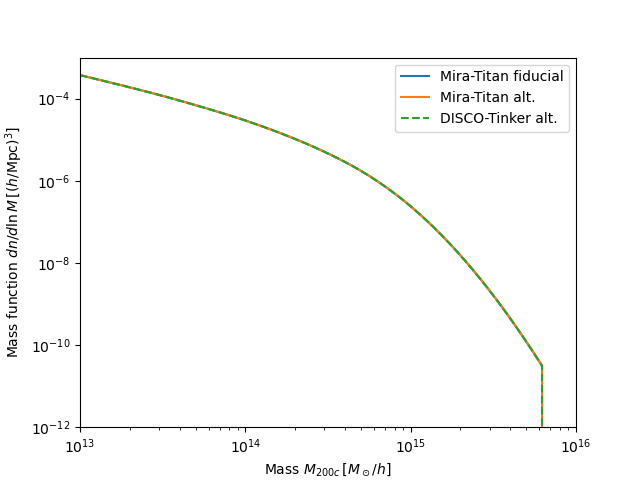

In [241]:
fig, ax = plt.subplots()

# ax.loglog( hmf.m, hmf.dndlnm, label='HMF-Tinker' )

# dndm,m = get_Tinker_MK( Pkm=Pkm, kmodes=kmodes, Mmin=1e13, Mmax=1e16, Delta = 200/Omegam, nM=512, param=param )
# ax.loglog( M, dNdlM,'--', label='DISCO-Tinker fiducial' )

plt.loglog(m, fMiraTitan_fiducial, '-', label='Mira-Titan fiducial' )

plt.loglog(m, fMiraTitan_test, '-', label='Mira-Titan alt.' )

fcorrection = jnp.dot( jacdNdlM / dNdlM[:,None], test_parameters - fiducial_parameters)
mcorrection = jnp.dot( jacM / M[:,None], test_parameters-fiducial_parameters )

pred_test = fMiraTitan_fiducial * jnp.exp(jnp.interp(jnp.log(m), jnp.log(M), fcorrection))
m_test = m * jnp.exp(jnp.interp(jnp.log(m), jnp.log(M), mcorrection))

ax.loglog( m_test, pred_test,'--', label='DISCO-Tinker alt.' )
# ax.loglog( m, pred_test,'--', label='DISCO-Tinker alt.' )

# plt.loglog(A[:,0], A[:,5]*A[:,0], '--')
plt.ylim(1e-12, 1e-3)
plt.xlim(1e13, 1e16)

plt.legend()
plt.xlabel('Mass $M_{200c}\,[M_\odot/h]$')
plt.ylabel('Mass function $dn/d\lnM\,[(h/\\mathrm{Mpc})^3]$')

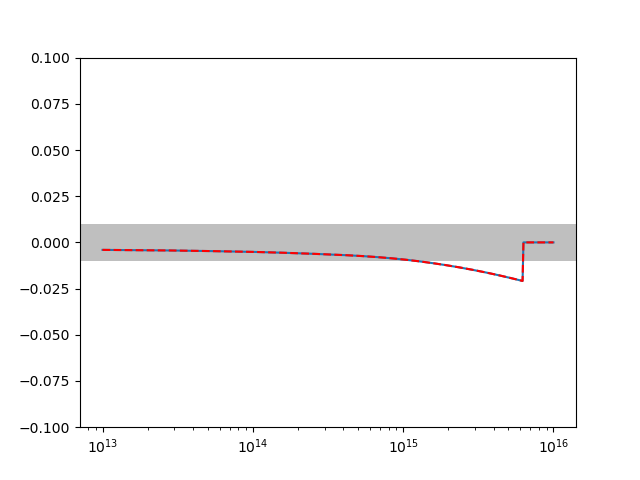

In [242]:
fig, ax = plt.subplots()

err = (jnp.exp(jnp.interp(jnp.log(m),jnp.log(m_test),jnp.log(pred_test))) - fMiraTitan_test) / fMiraTitan_test
errx = (pred_test - fMiraTitan_test) / fMiraTitan_test

err2 = (fMiraTitan_fiducial - fMiraTitan_test) / fMiraTitan_test


ax.semilogx( m, err )
# ax.semilogx( m, errx )


ax.semilogx( m, err2, 'r--' )

ax.set_ylim(-0.1,0.1)
# Add a gray horizontal band at 1 percent
ax.axhspan(-0.01, 0.01, facecolor='gray', alpha=0.5)


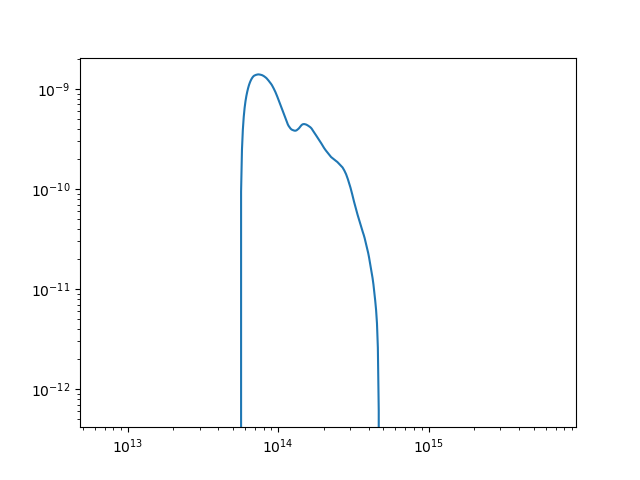

In [195]:
fig, ax = plt.subplots()
idx = 2
ax.loglog( M, jacdNdlM[:,idx]  )